In [1]:
import json
import os

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import statsmodels.api as sm

# Now create a bootstrap confidence interval around the a LOWESS fit
def lowess_with_confidence_bounds(
    x, y, eval_x, N=1000, conf_interval=0.95, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

Distribution gumbel, bias mode overexposure
Found 100 results
Distribution gumbel, bias mode competition
Found 100 results
Distribution exponomial, bias mode overexposure
Found 100 results
Distribution exponomial, bias mode competition
Found 100 results
Distribution bimix_gaussian, bias mode overexposure
Found 100 results
Distribution bimix_gaussian, bias mode competition
Found 100 results
Plotting gumbel overexposure Recommender_multinomial_logit
Plotting gumbel overexposure Recommender_exponomial
Plotting gumbel overexposure Recommender_NPMLE
Plotting gumbel competition Recommender_multinomial_logit
Plotting gumbel competition Recommender_exponomial
Plotting gumbel competition Recommender_NPMLE
Plotting exponomial overexposure Recommender_multinomial_logit
Plotting exponomial overexposure Recommender_exponomial
Plotting exponomial overexposure Recommender_NPMLE
Plotting exponomial competition Recommender_multinomial_logit
Plotting exponomial competition Recommender_exponomial
Plottin

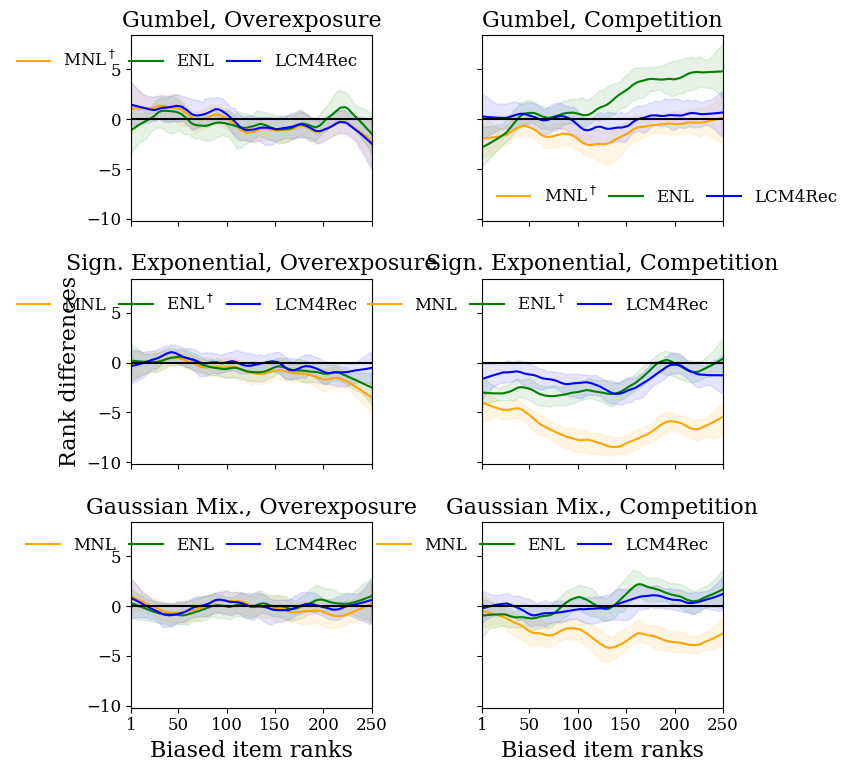

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

font = {'family' : 'serif'}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.family': 'serif'})
    
# Load data
result_table_dfs = []
pd.options.display.float_format = "{:,.3f}".format
for cdf_name in ["gumbel", "exponomial", "bimix_gaussian"]:
    for bias_mode in ["overexposure", "competition"]:
        print(f"Distribution {cdf_name}, bias mode {bias_mode}")
        
        dire_path = f"data/simulation_results/bias/{bias_mode}/{cdf_name}"

        # If path does not exist, print an error message and return
        if not os.path.exists(dire_path):
            print(f"No results found for {dire_path}")
            continue

        # Load all JSON files in the directory
        loaded_results = []
        for file in os.listdir(dire_path):
            if file.endswith(".json"):
                try:
                    with open(f"{dire_path}/{file}", "r") as f:
                        loaded_results.append(json.load(f))
                except Exception as e:
                    print(f"Could not load {file}: {e}")

        n_runs = len(loaded_results)

        print(f"Found {n_runs} results")

        # tmp
        loaded_results = [
            {key: val for key, val in r.items() if val != {}}
            for r in loaded_results
        ]

        # Create an empty DataFrame from the loaded results
        rows = []
        for r in loaded_results:
            for model_name in ["Recommender_multinomial_logit", "Recommender_exponomial", "Recommender_NPMLE"]:
                rows.extend(
                    [
                        [
                            cdf_name,
                            bias_mode,
                            model_name,
                            r["metrics"]["mean_bias_per_item"][model_name][i],
                            r["other"]["biased_item_ranks"][i],
                        ]
                        for i in range(len(r["metrics"]["mean_bias_per_item"][model_name]))
                    ]
                )
        rows = np.asarray(rows, dtype=object)
        results_df = pd.DataFrame(rows, columns=["cdf_name", "bias_mode", "model_name", "rank_diffs", "biased_item_ranks"], dtype=object)

        # print(results_df)

        # Append to bias_result_table_df
        result_table_dfs.append(results_df)

result_table_df = pd.concat(result_table_dfs, ignore_index=True)

# result_table_df

# For every cdf, bias mode and model, plot the rank differences vs the biased item ranks
color_by_model = {
    "Recommender_multinomial_logit": "orange",
    "Recommender_exponomial": "green",
    "Recommender_NPMLE": "blue",
}

model_title_names = {
    "Recommender_multinomial_logit": "MNL",
    "Recommender_exponomial": "ENL",
    "Recommender_NPMLE": "LCM4Rec",
}

distribution_title_names = {
    "gumbel": "Gumbel",
    "exponomial": "Sign. Exponential",
    "bimix_gaussian": "Gaussian Mix.",
}

bias_mode_title_names = {
    "overexposure": "Overexposure",
    "competition": "Competition",
}

correct_param_model_by_dist = {
    "gumbel": "Recommender_multinomial_logit",
    "exponomial": "Recommender_exponomial",
    "bimix_gaussian": None,
}

# Create a 3x2 grid of plots
fig, axes = plt.subplots(
    3, 
    2, 
    figsize=(8, 8), 
    sharex=True, 
    sharey=True,
)

for cdf_name in ["gumbel", "exponomial", "bimix_gaussian"]:
    for bias_mode in ["overexposure", "competition"]:
        ax = axes[0 if cdf_name == "gumbel" else 1 if cdf_name == "exponomial" else 2][0 if bias_mode == "overexposure" else 1]

        for model in result_table_df["model_name"].unique():
            print("Plotting", cdf_name, bias_mode, model)

            # Filter the data
            data = result_table_df[
                (result_table_df["cdf_name"] == cdf_name)
                & (result_table_df["bias_mode"] == bias_mode)
                & (result_table_df["model_name"] == model)
            ]

            # # Compute the window mean of all items wihtin a +- 50 ranks window
            xs = np.arange(1, 250)
            # ys = [
            #     np.mean([
            #         rd
            #         for rd, rank in zip(data["rank_diffs"].values, data["biased_item_ranks"].values)
            #         if np.abs(rank-x)<=20
            #     ])
            #     for x in xs
            # ]

            # print(f"Distribution {cdf_name}, bias mode {bias_mode}, model {model}: {data['rank_diffs'].values.mean():.2f}")

            # ax.plot(xs, ys, label=model_title_names[model] + ("$^\\dagger$" if model==correct_param_model_by_dist[cdf_name] else ""), c=color_by_model[model])

            # Compute the 95% confidence interval
            eval_x = np.linspace(xs.min(), xs.max(), 200)
            smoothed, bottom, top = lowess_with_confidence_bounds(
                data["biased_item_ranks"].values, data["rank_diffs"].values, eval_x, lowess_kw={"frac": 0.2}, N=100
            )

            # Plot the data
            # ax.scatter(data["biased_item_ranks"].values + 1, data["rank_diffs"], label=model, c=color_by_model[model], s=1)
            ax.plot(eval_x + 1, 
                    smoothed, 
                    label=model_title_names[model] + ("$^\\dagger$" if model==correct_param_model_by_dist[cdf_name] else ""), 
                    c=color_by_model[model])
            ax.fill_between(eval_x, bottom, top, alpha=0.1, color=color_by_model[model])

            # Bin the data into 5 bins
            # bin_size = 50
            # bins = np.arange(0, 250, bin_size)
            # bin_means = np.array(
            #     [
            #         np.mean(
            #             data["rank_diffs"].values[
            #                 (data["biased_item_ranks"].values >= bins[i]) & (data["biased_item_ranks"].values < bins[i+1])
            #             ]
            #         ) 
            #         for i in range(len(bins)-1)
            #     ]
            # )

            # Plot the data
            # ax.plot(bins[:-1] + 1, bin_means, label=model, c=color_by_model[model])

        ax.plot(np.arange(250), np.repeat(0, 250), c="black")

        ax.set_title(f"{distribution_title_names[cdf_name]}, {bias_mode_title_names[bias_mode]}")

        if cdf_name=="exponomial" and bias_mode=="overexposure":
            ax.set_ylabel("Rank differences")
        if cdf_name == "bimix_gaussian":
            ax.set_xlabel("Biased item ranks")
        
        ax.set_xlim(1, 250)
        # ax.set_ylim(-9, 5)

        ax.set_xticks([1, 50, 100, 150, 200, 250])
        # aspect_ratio = 2*(ax.get_ylim()[1]-ax.get_ylim()[0]) / (ax.get_xlim()[1]-ax.get_xlim()[0])
        # fig.set_size_inches(10, aspect_ratio * 10)

        # fig.legend()

        ax.legend(frameon=False, ncol=3, columnspacing=0.8)

# fig.text(0.5, 0.04, 'Biased item ranks', ha='center', )
# fig.text(0.04, 0.5, 'Rank differences', va='center', rotation='vertical')

plt.tight_layout()

# Save the figure
plt.savefig("data/out/tables and figures/rank_diffs_vs_biased_item_ranks.svg")

plt.show()



In [4]:
# Bin into groups
result_table_df.groupby(["cdf_name", "bias_mode", "model_name"]).agg("mean")

rank_diffs  \
cdf_name       bias_mode    model_name                                 
bimix_gaussian competition  Recommender_NPMLE                  0.118   
                            Recommender_exponomial             0.294   
                            Recommender_multinomial_logit     -2.856   
               overexposure Recommender_NPMLE                 -0.026   
                            Recommender_exponomial            -0.100   
                            Recommender_multinomial_logit     -0.247   
exponomial     competition  Recommender_NPMLE                 -1.571   
                            Recommender_exponomial            -2.021   
                            Recommender_multinomial_logit     -6.423   
               overexposure Recommender_NPMLE                 -0.212   
                            Recommender_exponomial            -0.581   
                            Recommender_multinomial_logit     -0.784   
gumbel         competition  Recommender_NPMLE                 -0.000   
                            Recommender_exponomial             1.701   
                            Recommender_multinomial_logit     -1.314   
               overexposure Recommender_NPMLE                 -0.258   
                            Recommender_exponomial            -0.418   
                            Recommender_multinomial_logit     -0.427   

                                                          biased_item_ranks  
cdf_name       bias_mode    model_name                                       
bimix_gaussian competition  Recommender_NPMLE                       126.744  
                            Recommender_exponomial                  126.744  
                            Recommender_multinomial_logit           126.744  
               overexposure Recommender_NPMLE                       123.071  
                            Recommender_exponomial                  123.071  
                            Recommender_multinomial_logit           123.071  
exponomial     competition  Recommender_NPMLE                       122.356  
                            Recommender_exponomial                  122.356  
                            Recommender_multinomial_logit           122.356  
               overexposure Recommender_NPMLE                       125.228  
                            Recommender_exponomial                  125.228  
                            Recommender_multinomial_logit           125.228  
gumbel         competition  Recommender_NPMLE                       125.310  
                            Recommender_exponomial                  125.310  
                            Recommender_multinomial_logit           125.310  
               overexposure Recommender_NPMLE                       124.926  
                            Recommender_exponomial                  124.926  
                            Recommender_multinomial_logit           124.926

Plotting gumbel overexposure Recommender_multinomial_logit ...
Plotting gumbel overexposure Recommender_exponomial ...
Plotting gumbel overexposure Recommender_NPMLE ...
Plotting gumbel competition Recommender_multinomial_logit ...
Plotting gumbel competition Recommender_exponomial ...
Plotting gumbel competition Recommender_NPMLE ...
Plotting exponomial overexposure Recommender_multinomial_logit ...
Plotting exponomial overexposure Recommender_exponomial ...
Plotting exponomial overexposure Recommender_NPMLE ...
Plotting exponomial competition Recommender_multinomial_logit ...
Plotting exponomial competition Recommender_exponomial ...
Plotting exponomial competition Recommender_NPMLE ...
Plotting bimix_gaussian overexposure Recommender_multinomial_logit ...
Plotting bimix_gaussian overexposure Recommender_exponomial ...
Plotting bimix_gaussian overexposure Recommender_NPMLE ...
Plotting bimix_gaussian competition Recommender_multinomial_logit ...
Plotting bimix_gaussian competition Re

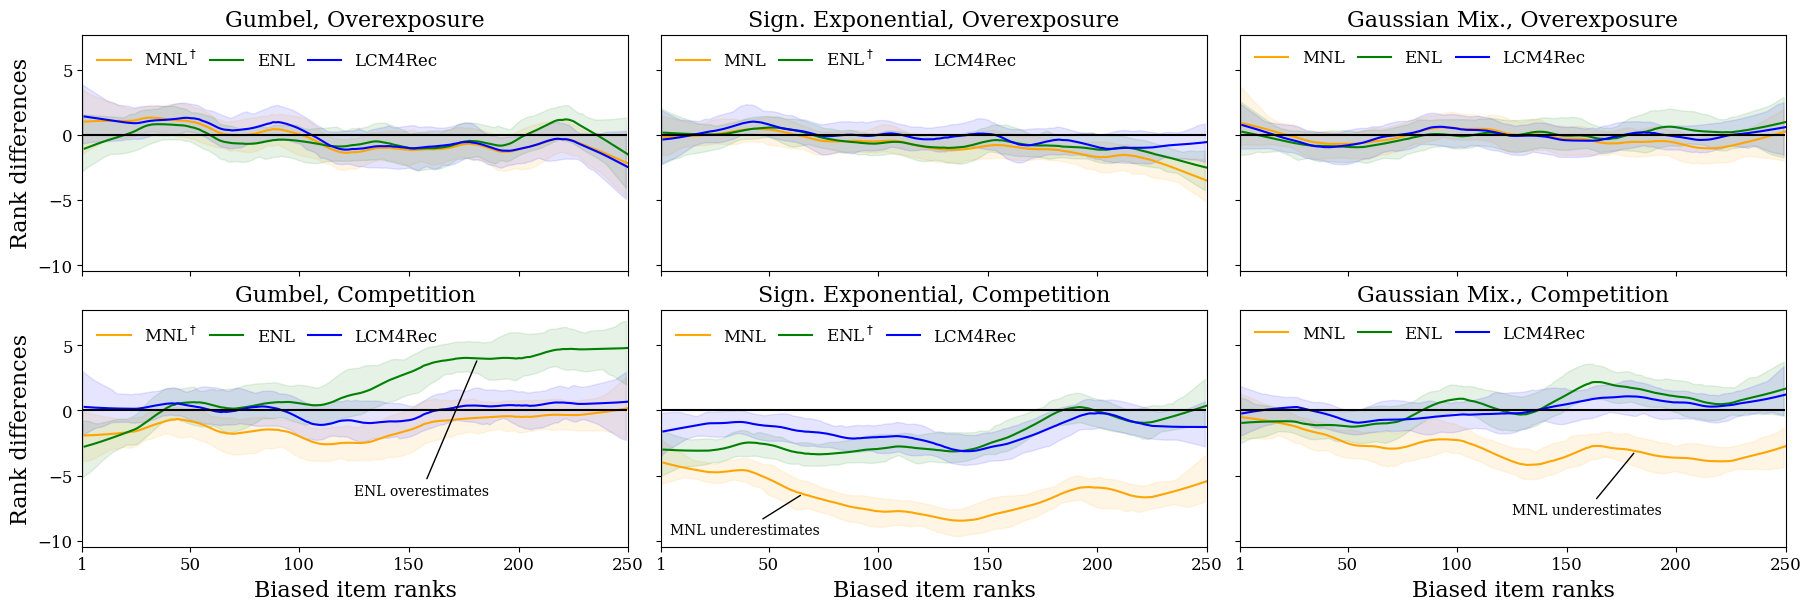

In [5]:
# Transposed figure
# Create a 2x3 grid of plots
fig, axes = plt.subplots(
    2, 
    3, 
    figsize=(18, 6), 
    constrained_layout=True,
    sharex=True, 
    sharey=True,
)

for cdf_name in ["gumbel", "exponomial", "bimix_gaussian"]:
    for bias_mode in ["overexposure", "competition"]:
        ax = axes[0 if bias_mode == "overexposure" else 1][0 if cdf_name == "gumbel" else 1 if cdf_name == "exponomial" else 2]

        for model in result_table_df["model_name"].unique():
            print("Plotting", cdf_name, bias_mode, model, "...")

            # Filter the data
            data = result_table_df[
                (result_table_df["cdf_name"] == cdf_name)
                & (result_table_df["bias_mode"] == bias_mode)
                & (result_table_df["model_name"] == model)
            ]

            # # Compute the window mean of all items wihtin a +- 50 ranks window
            xs = np.arange(1, 250)
            # ys = [
            #     np.mean([
            #         rd
            #         for rd, rank in zip(data["rank_diffs"].values, data["biased_item_ranks"].values)
            #         if np.abs(rank-x)<=20
            #     ])
            #     for x in xs
            # ]

            # print(f"Distribution {cdf_name}, bias mode {bias_mode}, model {model}: {data['rank_diffs'].values.mean():.2f}")

            # ax.plot(xs, ys, label=model_title_names[model] + ("$^\\dagger$" if model==correct_param_model_by_dist[cdf_name] else ""), c=color_by_model[model])

            # Compute the 95% confidence interval
            eval_x = np.linspace(xs.min(), xs.max(), 200)
            smoothed, bottom, top = lowess_with_confidence_bounds(
                data["biased_item_ranks"].values, data["rank_diffs"].values, eval_x, lowess_kw={"frac": 0.2}, N=100
            )

            # Plot the data
            # ax.scatter(data["biased_item_ranks"].values + 1, data["rank_diffs"], label=model, c=color_by_model[model], s=1)
            ax.plot(eval_x + 1, 
                    smoothed, 
                    label=model_title_names[model] + ("$^\\dagger$" if model==correct_param_model_by_dist[cdf_name] else ""), 
                    c=color_by_model[model])
            ax.fill_between(eval_x, bottom, top, alpha=0.1, color=color_by_model[model])

            # Bin the data into 5 bins
            # bin_size = 50
            # bins = np.arange(0, 250, bin_size)
            # bin_means = np.array(
            #     [
            #         np.mean(
            #             data["rank_diffs"].values[
            #                 (data["biased_item_ranks"].values >= bins[i]) & (data["biased_item_ranks"].values < bins[i+1])
            #             ]
            #         ) 
            #         for i in range(len(bins)-1)
            #     ]
            # )

            # Plot the data
            # ax.plot(bins[:-1] + 1, bin_means, label=model, c=color_by_model[model])

            # Annotate
            if cdf_name=="gumbel" and bias_mode=="competition" and model=="Recommender_exponomial":
                ax.annotate(
                    text="ENL overestimates", 
                    xy=(
                        eval_x[np.argmin(np.abs(eval_x-180))]+1, 
                        smoothed[np.argmin(np.abs(eval_x-180))]
                    ), 
                    xytext=(125,-6.5), 
                    arrowprops={"arrowstyle": "-"},
                    fontsize=10,
                )
            elif cdf_name=="exponomial" and bias_mode=="competition" and model=="Recommender_multinomial_logit":
                ax.annotate(
                    text="MNL underestimates", 
                    xy=(
                        eval_x[np.argmin(np.abs(eval_x-65))]+1, 
                        smoothed[np.argmin(np.abs(eval_x-65))]
                    ), 
                    xytext=(5,-9.5), 
                    arrowprops={"arrowstyle": "-"},
                    fontsize=10,
                )
            elif cdf_name=="bimix_gaussian" and bias_mode=="competition" and model=="Recommender_multinomial_logit":
                ax.annotate(
                    text="MNL underestimates", 
                    xy=(
                        eval_x[np.argmin(np.abs(eval_x-180))]+1, 
                        smoothed[np.argmin(np.abs(eval_x-180))]
                    ), 
                    xytext=(125,-8), 
                    arrowprops={"arrowstyle": "-"},
                    fontsize=10,
                )

        ax.plot(np.arange(250), np.repeat(0, 250), c="black")

        ax.set_title(f"{distribution_title_names[cdf_name]}, {bias_mode_title_names[bias_mode]}")

        if cdf_name=="gumbel":
            ax.set_ylabel("Rank differences")
        if bias_mode=="competition":
            ax.set_xlabel("Biased item ranks")
        
        ax.set_xlim(1, 250)
        # ax.set_ylim(-9, 5)

        ax.set_xticks([1, 50, 100, 150, 200, 250])
        # aspect_ratio = 2*(ax.get_ylim()[1]-ax.get_ylim()[0]) / (ax.get_xlim()[1]-ax.get_xlim()[0])
        # fig.set_size_inches(10, aspect_ratio * 10)

        # fig.legend()

        ax.legend(frameon=False, ncol=3, columnspacing=0.8, loc="upper left")

# fig.text(0.5, 0.04, 'Biased item ranks', ha='center', )
# fig.text(0.04, 0.5, 'Rank differences', va='center', rotation='vertical')

# plt.tight_layout()

# Save the figure
plt.savefig("data/out/tables and figures/rank_diffs_vs_biased_item_ranks_orthogonal.svg") # , bbox_inches='tight')

plt.show()

